In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LeakyReLU, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

2022-06-21 14:42:16.771286: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
df = pd.read_csv("data/cells.csv", delimiter=' ', header=None)

In [44]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
def build_generator():
    #Initializing a neural network
    generator = Sequential()
    
    #Adding an Input layer to the network
    generator.add(Dense(units=256, input_dim=121))    

    #Activating the layer with LeakyReLU activation function
    generator.add(LeakyReLU(0.2))

    #Applying Batch Normalization 
    generator.add(BatchNormalization(momentum=0.8))

    #Adding a second layer	
    generator.add(Dense(units=512))
    
    #Adding a third layer	
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    #The output layer with 121(11x11) nodes
    generator.add(Dense(units=121, activation='tanh'))
    
    #Compiling the Generator Network with loss and optimizer functions
    generator.compile(loss='binary_crossentropy', optimizer= Adam(learning_rate=0.0002, beta_1=0.5))
    return generator

In [46]:
def build_discriminator():
    #Initializing a neural network
    discriminator=Sequential()
    
    #Adding an Input layer to the network
    discriminator.add(Dense(units=1024, input_dim= 121))
    
    #Activating the layer with LeakyReLU activation function
    discriminator.add(LeakyReLU(0.2))
    
    #Adding a dropout layer to reduce overfitting
    discriminator.add(Dropout(0.2))
       
    #Adding a second layer
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    #Adding a third layer	 
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    #Adding a forth layer
    discriminator.add(Dense(units=128))
    discriminator.add(LeakyReLU(0.2))
    
    #Adding the output layer with sigmoid activation
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    #Compiling the Discriminator Network with loss and optimizer functions
    discriminator.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate=0.0002, beta_1=0.5))

    return discriminator

In [47]:
def gan_net(generator, discriminator):
  
    #Setting the trainable parameter of discriminator to False
    discriminator.trainable=False
    
    #Instantiates a Keras tensor of shape 121 (Noise shape)
    inp = Input(shape=(121,))
    
    #Feeds the input noise to the generator and stores the output in X
    X = generator(inp)
    
    #Feeds the output from generator(X) to the discriminator and stores the result in out
    out= discriminator(X)
    
    #Creates a model include all layers required in the computation of out given inp.
    gan= Model(inputs=inp, outputs=out)
    
    #Compiling the GAN Network
    gan.compile(loss='binary_crossentropy', optimizer = 'adam',metrics=['acc', 'mse', 'mae'])
    
    return gan

In [48]:
def get_output(epoch, generator, dim = (11,11), figsize=(15,15)):
    #Generate a normally distributed noise of shape(11X11)
    noise= np.random.normal(loc=0, scale=1, size=[121, 121]) 
    #Generate an image for the input noise
    generated_events = generator.predict(noise)
    #Reshape the generated image 
    pd.DataFrame(generated_events).to_csv('output/gan_gen.csv')
    generated_events = generated_events.reshape(121,11,11)

In [49]:

def train(X_train, epochs, batch_size):
    
    
    #Initializing the GAN 
    generator= build_generator()
    discriminator= build_discriminator()
    gan = gan_net(generator,discriminator)
    
    # Training the model for specified epochs
    
    for epoch in range(1,epochs+1 ):
        print("Epoch ", epoch)
        
        for _ in range(batch_size):
          
            #Random noise with size batch_sizex121
            noise= np.random.normal(0,1, [batch_size, 121])
            #print(noise.shape)
            #Generating images from noise
            generated_events = generator.predict(noise)
            
            #taking random images from the training set 
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            #print(image_batch.shape)
            #Creating a new training set with real and fake images 
            X= np.concatenate([image_batch, generated_events])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)  
            y_dis[:batch_size]=1.0 # label for real images
            
            #Training the discriminator with real and generated images
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Labelling the generated images as real images(1) to trick the discriminator
            noise= np.random.normal(0,1, [batch_size, 121])
            y_gen = np.ones(batch_size)
            
            #Freezing the weights of the discriminator while training generator
            discriminator.trainable=False
            
            #Training the gan network
            gan.train_on_batch(noise, y_gen)
        
        
        get_output(epoch,generator,dim = (11,11) , figsize=(15,15))


X_train = df.values
train(X_train,epochs = 10, batch_size = 121)

Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10


In [3]:
res = pd.read_csv("output/gan_gen.csv")
res.head(5)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,111,112,113,114,115,116,117,118,119,120
0,0,0.014756,0.014108,0.019485,-0.026489,-0.012375,-0.002945,0.008651,0.017493,0.000943,...,0.035589,0.028002,0.001695,-0.006164,0.012962,-0.032692,-0.006337,-0.000331,0.013381,-0.051372
1,1,0.022218,0.028975,0.008053,0.031489,-0.009512,0.015109,-0.006133,0.016440,0.006342,...,0.019838,0.007502,0.025711,-0.018708,0.011220,0.002753,-0.003586,0.012555,-0.024598,-0.029104
2,2,0.001173,0.000354,-0.023578,0.000669,0.028706,-0.000032,-0.015763,0.012726,0.026964,...,0.015130,0.024837,-0.014045,-0.018562,-0.007705,0.007690,0.030215,0.008734,0.016896,0.001359
3,3,0.033191,-0.027192,0.039546,0.035074,-0.022401,0.017563,0.008327,0.004671,0.008763,...,-0.028608,0.036535,0.008556,-0.021570,0.043284,0.020197,0.044384,0.023742,-0.001806,-0.030333
4,4,0.013516,0.021033,0.028998,-0.004222,0.006816,0.001493,-0.010133,0.002417,-0.000708,...,-0.001437,0.020482,-0.010299,0.025238,0.013256,0.008285,-0.009108,0.025362,-0.000143,0.002925


In [4]:
res.drop(res.columns[[0]], axis=1, inplace=True)

In [5]:
res.head(5)

,0,1,2,3,4,5,6,7,8,9,...,111,112,113,114,115,116,117,118,119,120
0,0.014756,0.014108,0.019485,-0.026489,-0.012375,-0.002945,0.008651,0.017493,0.000943,0.014254,...,0.035589,0.028002,0.001695,-0.006164,0.012962,-0.032692,-0.006337,-0.000331,0.013381,-0.051372
1,0.022218,0.028975,0.008053,0.031489,-0.009512,0.015109,-0.006133,0.016440,0.006342,-0.008156,...,0.019838,0.007502,0.025711,-0.018708,0.011220,0.002753,-0.003586,0.012555,-0.024598,-0.029104
2,0.001173,0.000354,-0.023578,0.000669,0.028706,-0.000032,-0.015763,0.012726,0.026964,-0.020810,...,0.015130,0.024837,-0.014045,-0.018562,-0.007705,0.007690,0.030215,0.008734,0.016896,0.001359
3,0.033191,-0.027192,0.039546,0.035074,-0.022401,0.017563,0.008327,0.004671,0.008763,-0.001644,...,-0.028608,0.036535,0.008556,-0.021570,0.043284,0.020197,0.044384,0.023742,-0.001806,-0.030333
4,0.013516,0.021033,0.028998,-0.004222,0.006816,0.001493,-0.010133,0.002417,-0.000708,0.017082,...,-0.001437,0.020482,-0.010299,0.025238,0.013256,0.008285,-0.009108,0.025362,-0.000143,0.002925


In [6]:
import seaborn as sn
import os

In [7]:
ndf=np.array(df)
ndf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
res[res<0] = 0
res=np.array(res)
res

array([[0.0147557 , 0.01410787, 0.01948452, ..., 0.        , 0.01338113,
        0.        ],
       [0.02221811, 0.02897501, 0.00805313, ..., 0.01255478, 0.        ,
        0.        ],
       [0.00117281, 0.00035392, 0.        , ..., 0.00873411, 0.01689563,
        0.0013588 ],
       ...,
       [0.00383967, 0.        , 0.01696183, ..., 0.02045751, 0.05891985,
        0.        ],
       [0.01964575, 0.        , 0.        , ..., 0.02251575, 0.04233811,
        0.        ],
       [0.00992446, 0.00583768, 0.        , ..., 0.        , 0.00936003,
        0.        ]])

In [9]:
""" plt.plot(ndf[i],label='true',color='red')
plt.plot(res[i],label='pred',color='blue')
plt.legend()
plt.title('reshape(5000, 121)_GAN') """

for i in range(9): # event_number
    plt.plot(ndf[i],label='true',color='red')
    plt.plot(res[i],label='pred',color='blue')
    plt.legend()
    plt.title('reshape(5000, 121)_GAN event {}'.format(i))
    plt.savefig('result_plots/reshape(5000, 121)_GAN_true_pred_comp/reshape(5000, 121)_GAN_event_{}.png'.format(i))
    plt.close()

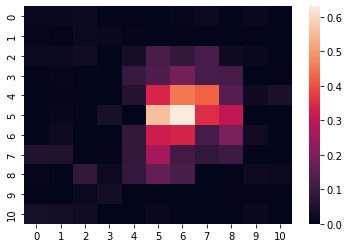

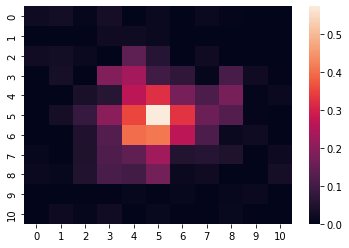

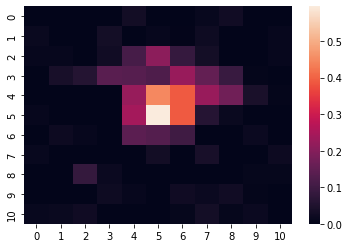

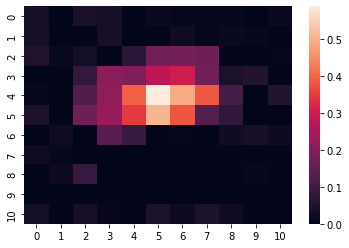

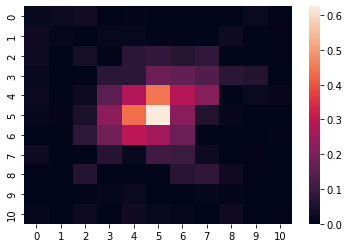

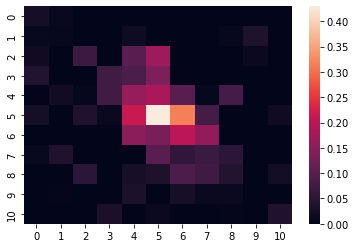

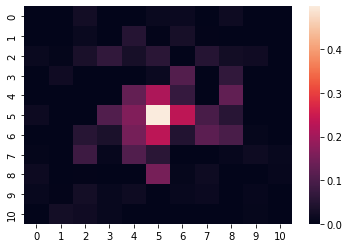

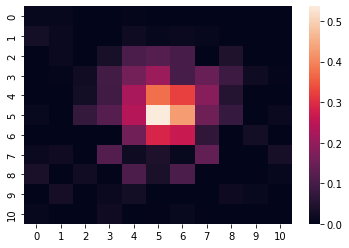

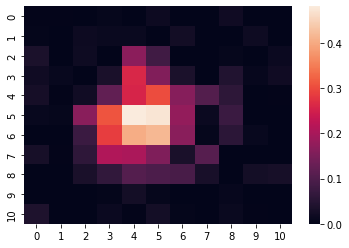

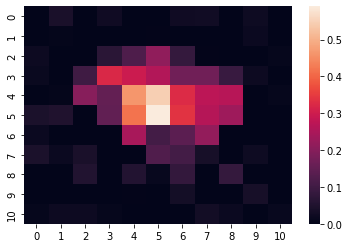

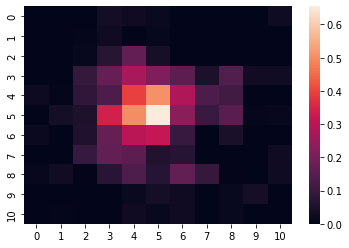

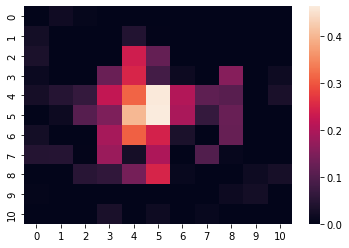

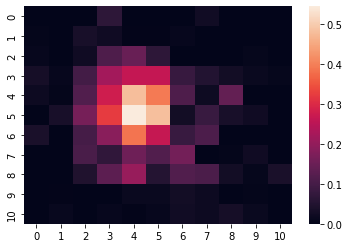

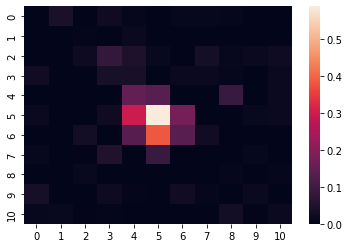

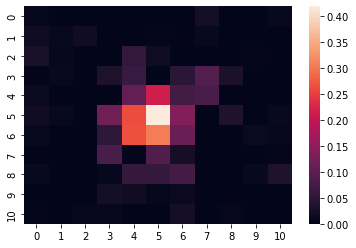

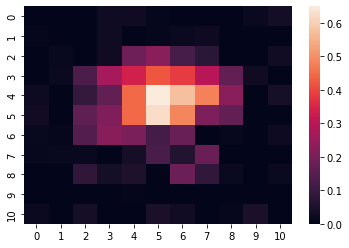

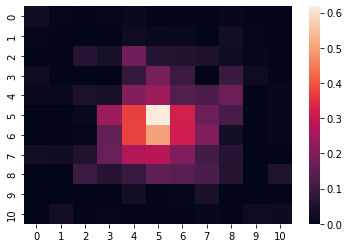

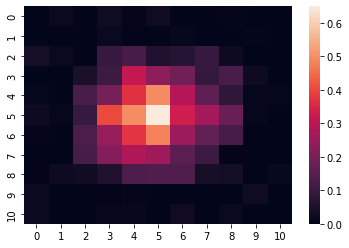

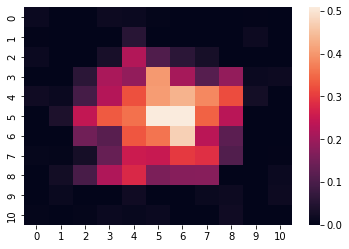

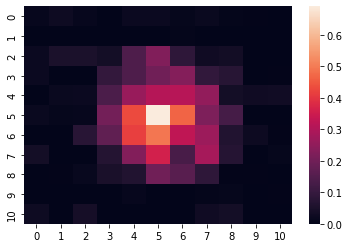

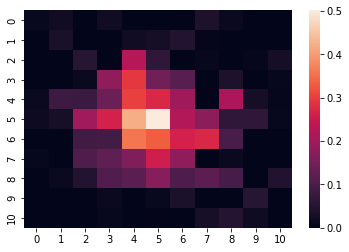

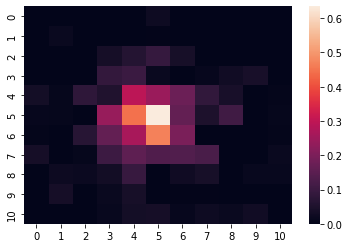

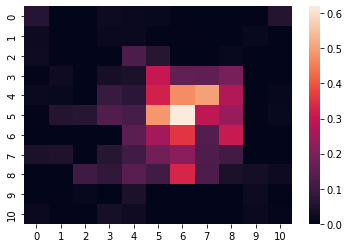

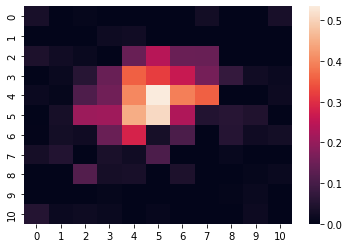

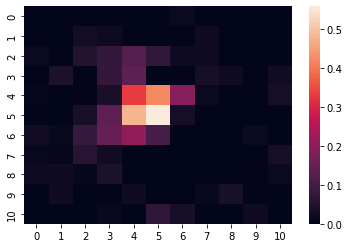

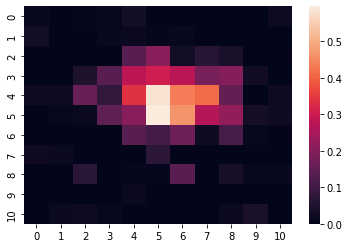

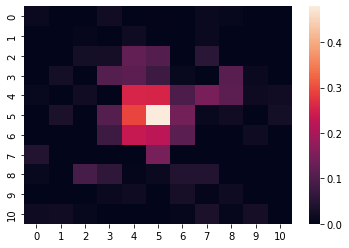

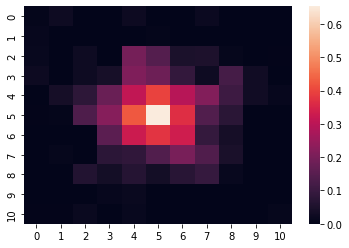

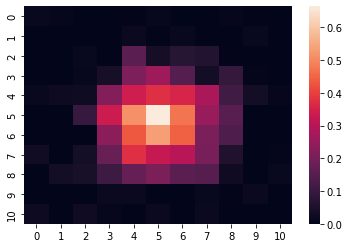

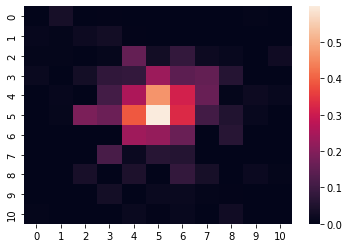

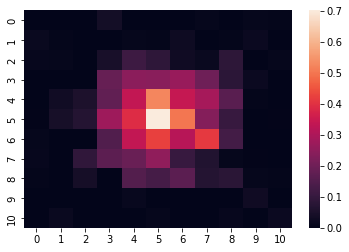

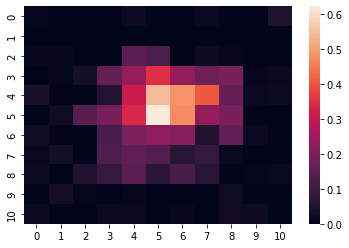

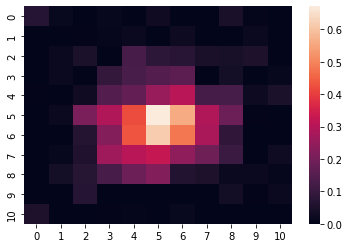

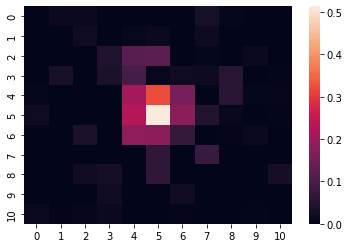

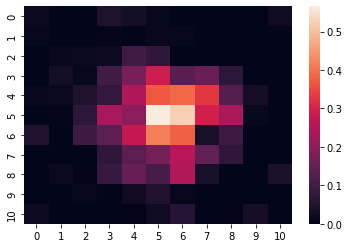

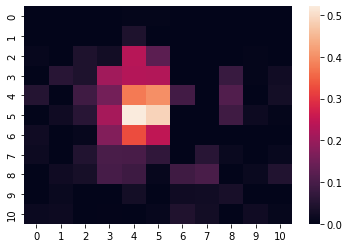

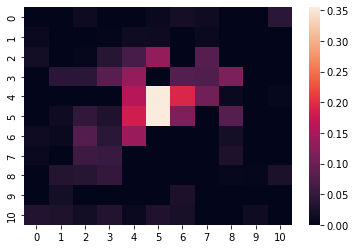

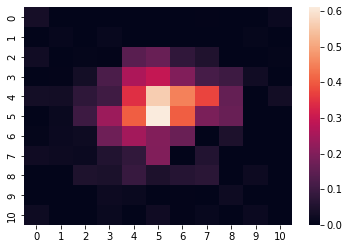

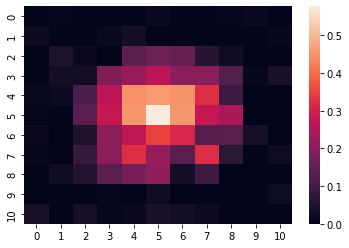

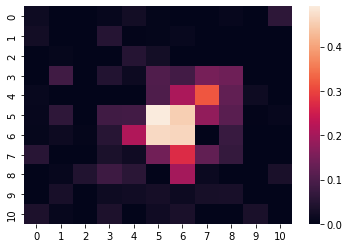

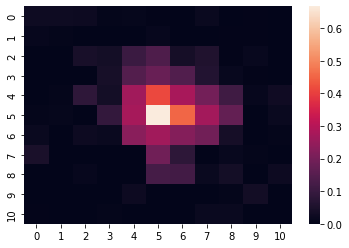

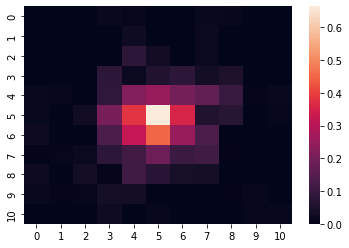

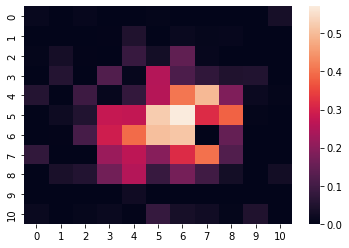

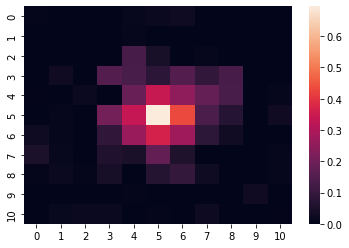

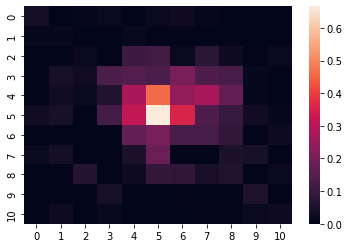

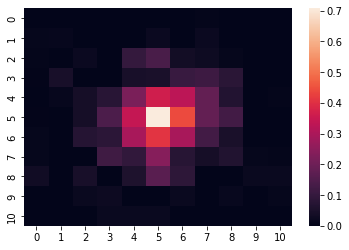

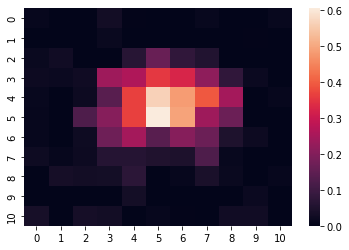

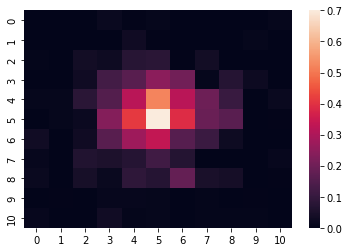

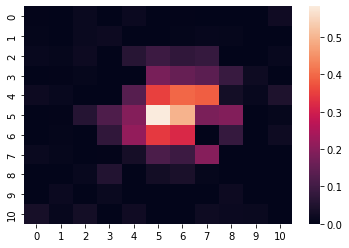

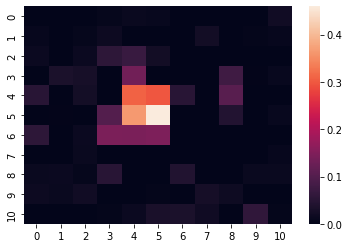

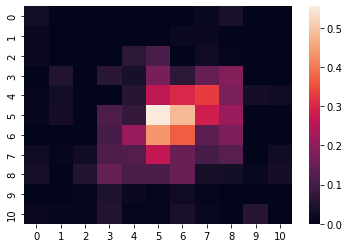

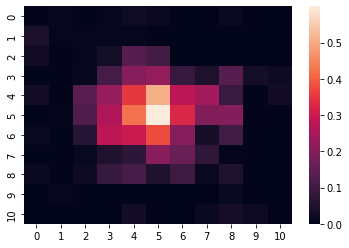

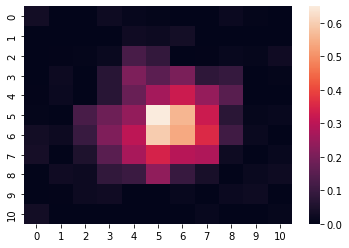

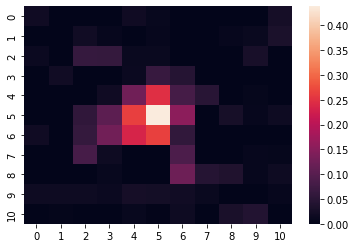

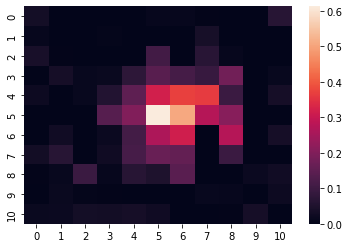

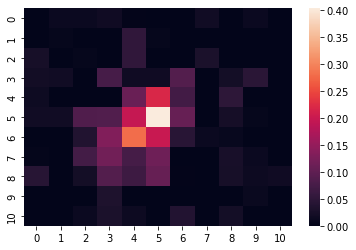

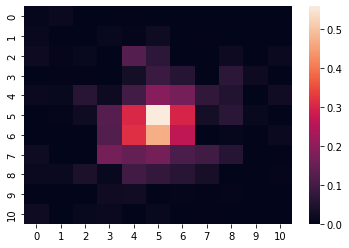

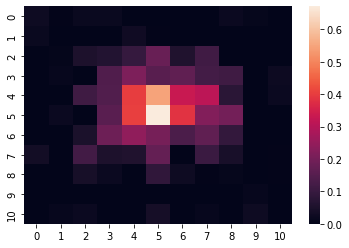

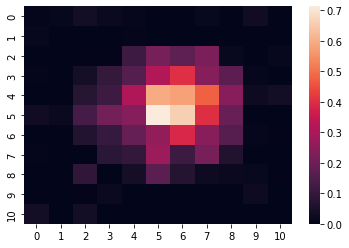

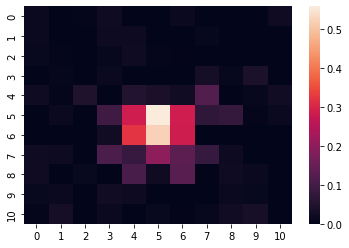

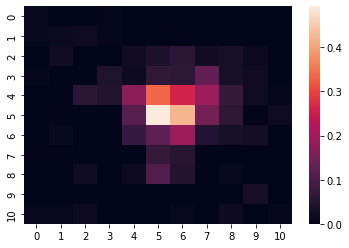

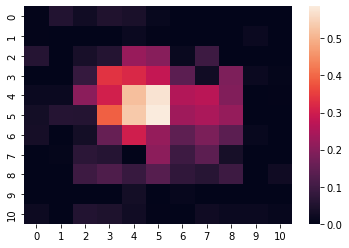

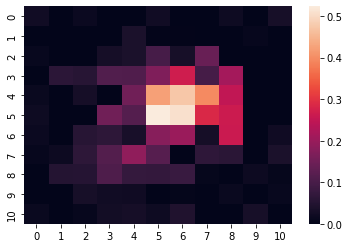

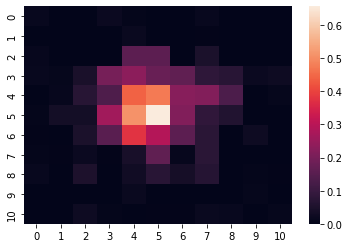

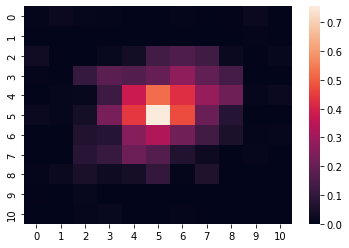

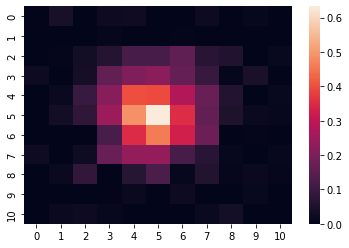

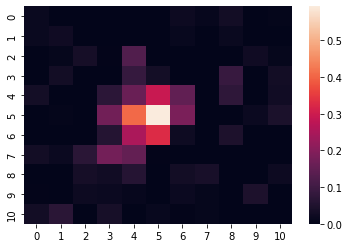

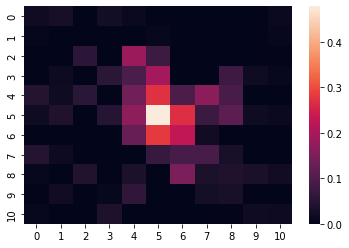

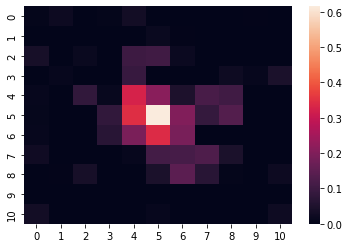

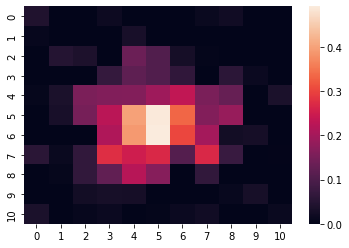

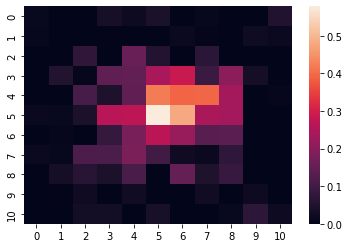

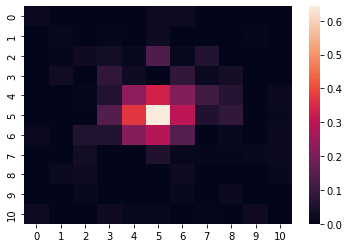

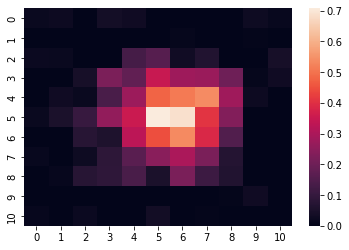

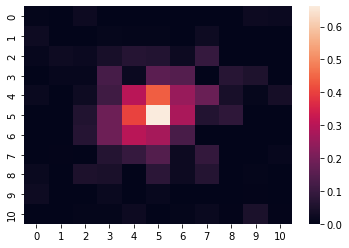

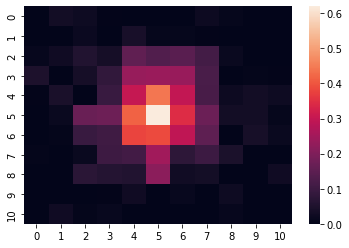

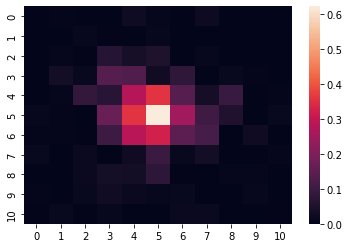

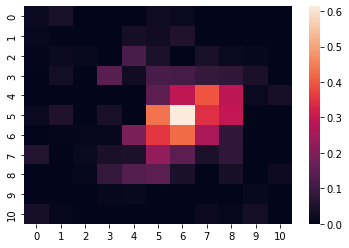

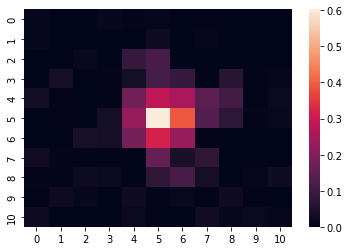

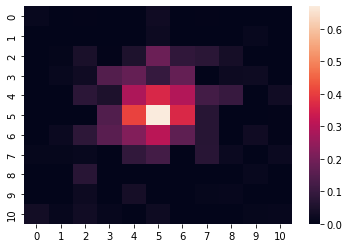

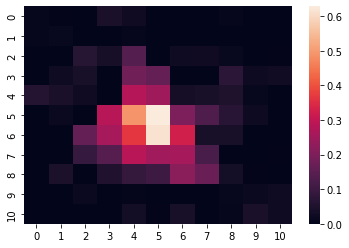

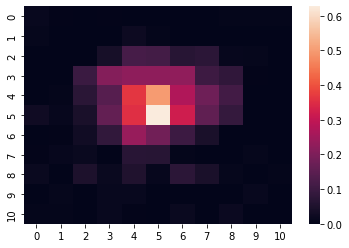

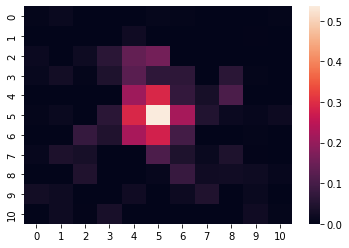

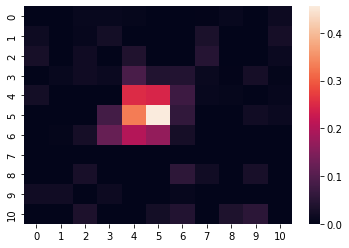

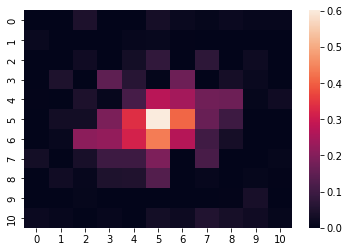

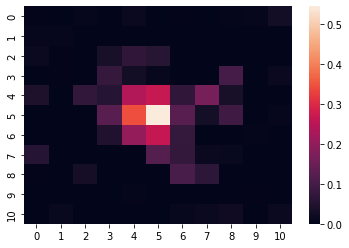

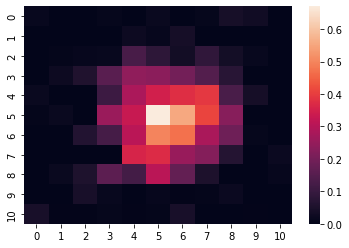

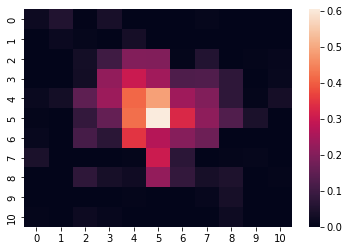

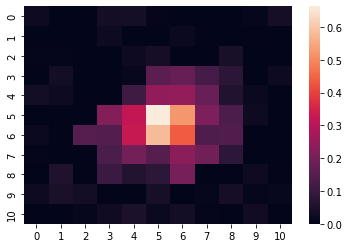

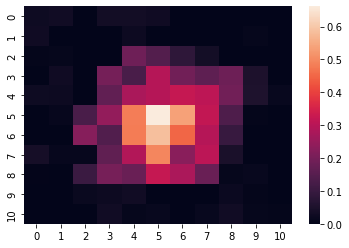

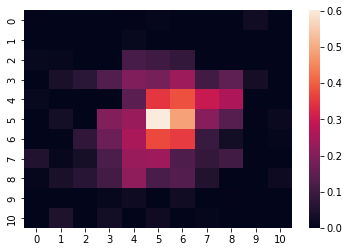

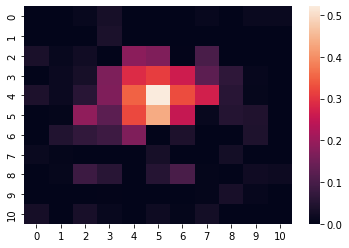

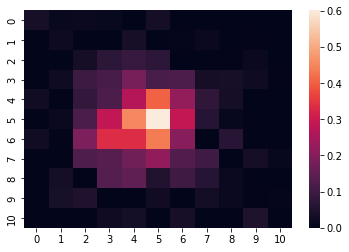

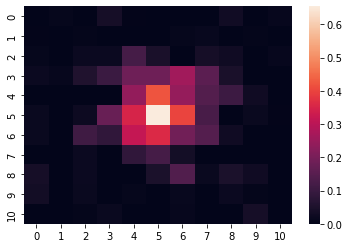

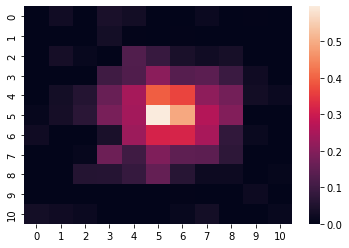

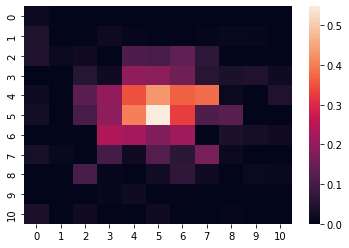

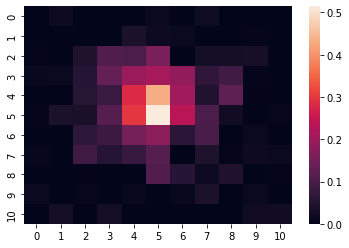

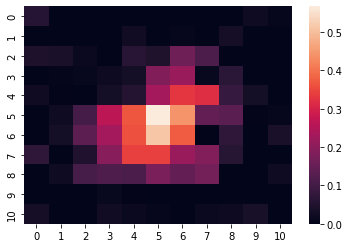

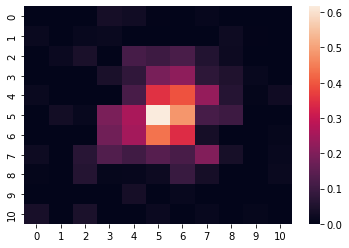

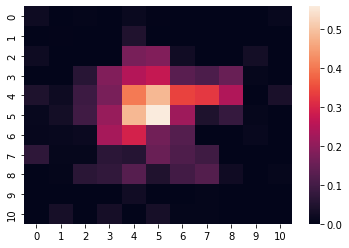

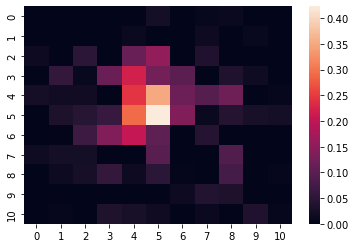

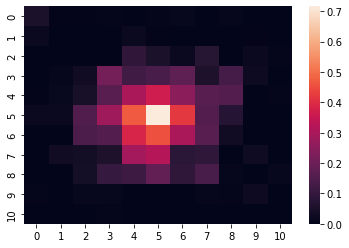

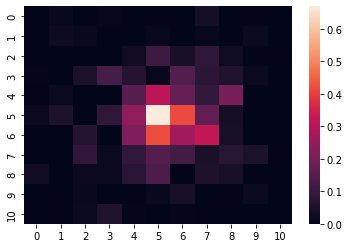

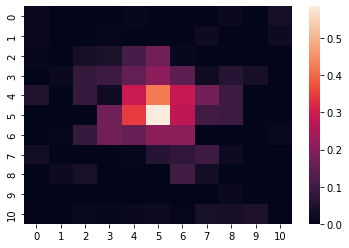

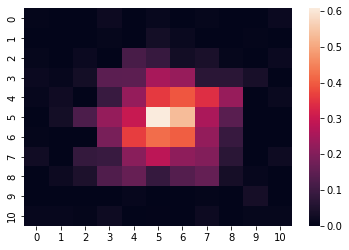

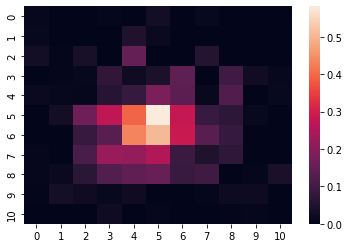

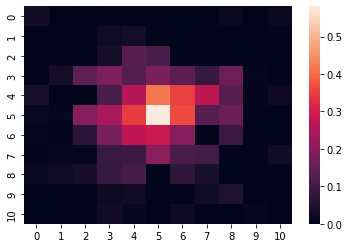

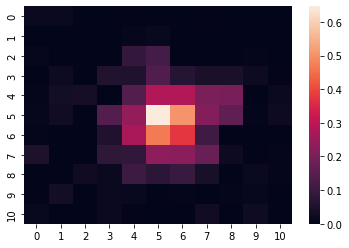

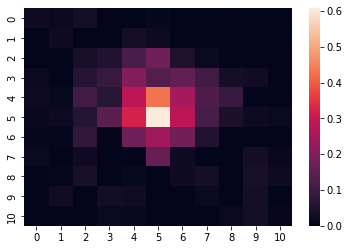

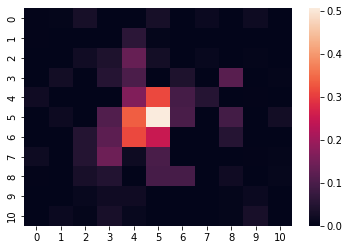

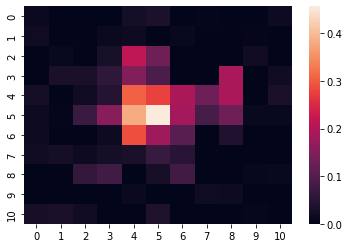

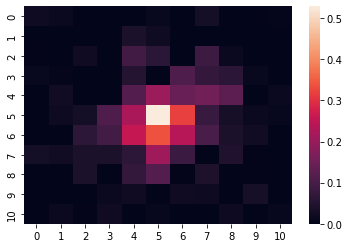

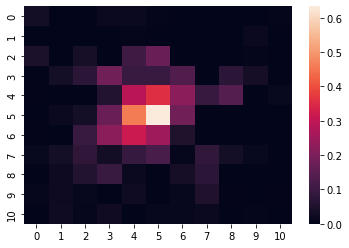

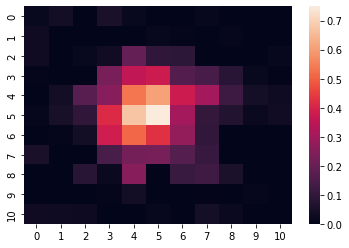

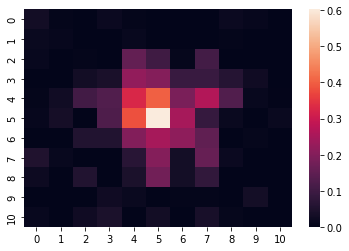

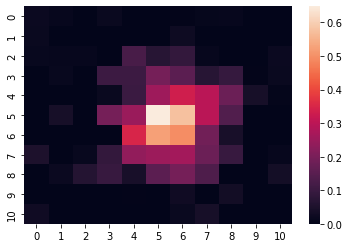

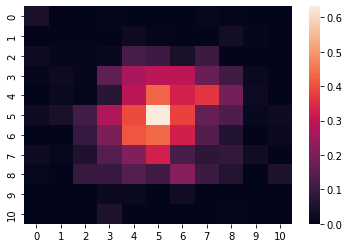

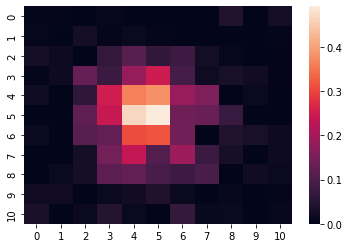

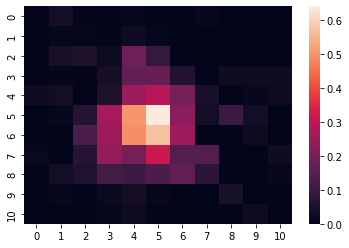

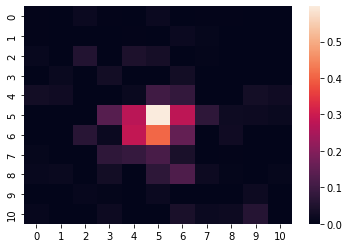

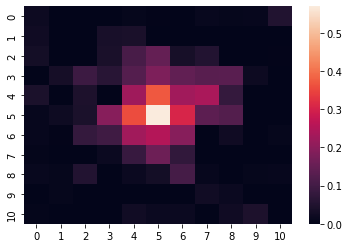

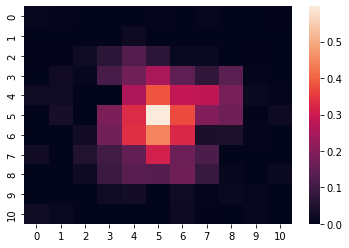

In [57]:
for i in range(res.shape[0]):
  arr = np.array(res[i])
  arr = np.reshape( arr, (11, 11))
  sn.heatmap(data = arr)
  name = "result_" + str(i) + ".png"
  plt.savefig(os.path.join("result_plots/GAN", name))
  plt.show()